# Northwind Dataset - Statistical Analysis

In [75]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import kstest
from scipy.stats import ks_2samp
from sklearn.preprocessing import StandardScaler
import warnings
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_style('darkgrid')
from statsmodels.stats.power import TTestIndPower

## Connecting to SQL database

In [68]:
conn = sqlite3.Connection('Northwind_small.sqlite')
cur = conn.cursor()

## Q1 Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

In [69]:
cur.execute(""" SELECT * FROM orderdetail;""")

df = pd.DataFrame(cur.fetchall())
df.columns = [i[0] for i in cur.description]
print(df.shape)
df.head()

(2155, 6)


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


#### Verifying that there are no missing entries

In [70]:
print(df.dtypes)
df.isna().sum()

Id            object
OrderId        int64
ProductId      int64
UnitPrice    float64
Quantity       int64
Discount     float64
dtype: object


Id           0
OrderId      0
ProductId    0
UnitPrice    0
Quantity     0
Discount     0
dtype: int64

####  Lets start with discount 0 vs any discount discount > 0. We will at first see the quatity ordered for all products

In [71]:
analysis_df = df[['ProductId','Quantity','Discount']]

analysis_df_nodisc = analysis_df[analysis_df.Discount==0]
analysis_df_disc = analysis_df[analysis_df.Discount >0]

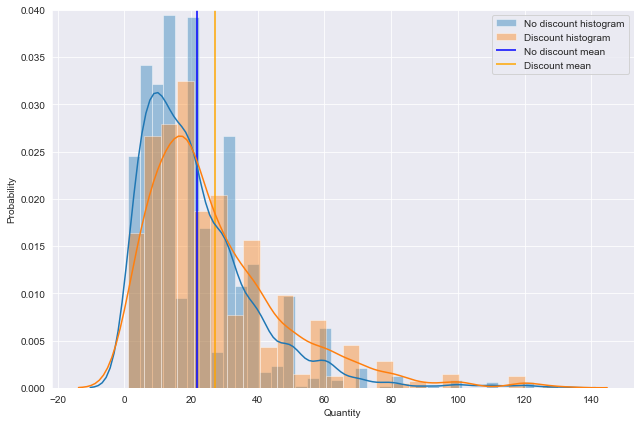

In [76]:
plt.figure(figsize=(9,6))
plt.ylim([0,0.04])
plt.vlines(analysis_df_nodisc['Quantity'].mean(),0,0.04,color='b',label='No discount mean')
plt.vlines(analysis_df_disc['Quantity'].mean(),0,0.04,color='orange',label='Discount mean')
sns.distplot(analysis_df_nodisc['Quantity'],label='No discount histogram')
sns.distplot(analysis_df_disc['Quantity'],label='Discount histogram')
plt.ylabel('Probability')
plt.legend()
plt.tight_layout()


#### The distributions are not exactly normal. But we will perform a Welch's t-test assuming that they are. We will also perform a KS test

In [73]:
print('The p-value that the no discount and the discounted quatities come from the same distribution using the Welch t-test is',ttest_ind(analysis_df_nodisc['Quantity'],analysis_df_disc['Quantity'],equal_var=False)[1])
print('The p-value that the no discount and the discounted quatities come from the same distribution using the KS test is',ks_2samp(analysis_df_nodisc['Quantity'],analysis_df_disc['Quantity'])[1])
print('The p-value that the no discount and the discounted quatities come from the same distribution using the Welch t-test is',ttest_ind(np.log1p(analysis_df_nodisc['Quantity']),np.log1p(analysis_df_disc['Quantity']),equal_var=False)[1])


The p-value that the no discount and the discounted quatities come from the same distribution using the Welch t-test is 5.65641429030433e-10
The p-value that the no discount and the discounted quatities come from the same distribution using the KS test is 4.880136585949657e-07
The p-value that the no discount and the discounted quatities come from the same distribution using the Welch t-test is 2.7197092865123905e-10


#### Its clear that the quantities come from different distributuions

In [84]:
#correct if the population S.D. is expected to be equal for the two groups.
def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    mx = np.mean(x)
    my = np.mean(y)
    sx = np.std(x,ddof=1)
    sy = np.std(y,ddof=1)
    return (mx - my) / np.sqrt(((nx-1)*(sx ** 2) + (ny-1)*(sy** 2)) / dof)

In [85]:
power_analysis = TTestIndPower()

Welch t-test: 1.0
KS test: 1.0
Power 0.04999999999999989
Welch t-test: 1.75086380996203e-05
KS test: 0.0015302697594749004
Power 0.8912481559067065
Welch t-test: 0.022088155855764333
KS test: 0.15304009590182588
Power 0.40265368971993154
Welch t-test: 2.2330442359905475e-05
KS test: 0.0019990429636369544
Power 0.8857811404622239
Welch t-test: 9.681494600873715e-05
KS test: 0.005978576733794316
Power 0.8096165478073782
Welch t-test: 5.136632223716805e-05
KS test: 8.236681807693991e-05
Power 0.8692702587734366


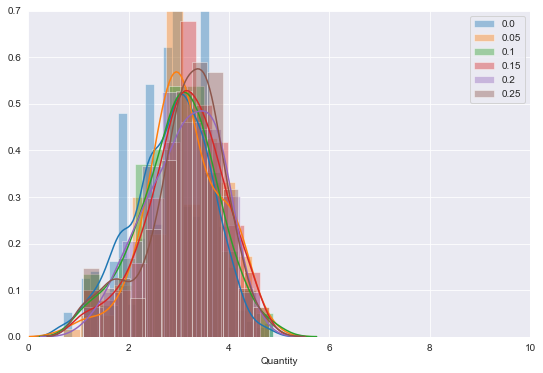

In [90]:
plt.figure(figsize=(9,6))
plt.xlim([0,10])
plt.ylim([0,.7])
disc = analysis_df.Discount.unique()
disc.sort()
for d in disc:
    df_plot = analysis_df[analysis_df.Discount==d]['Quantity']
    if len(df_plot) >10:
        sns.distplot(np.log1p(df_plot),label=str(d))
        print('Welch t-test:',ttest_ind(np.log1p(df_plot),np.log1p(analysis_df_nodisc['Quantity']),equal_var=False)[1])
        print('KS test:', ks_2samp(np.log1p(df_plot),np.log1p(analysis_df_nodisc['Quantity']))[1])
        print('Power',power_analysis.solve_power(effect_size = cohen_d(np.log1p(df_plot),np.log1p(analysis_df_nodisc['Quantity']))
                                                 ,alpha = 0.05, nobs1 = len(df_plot)))
plt.legend()

#### Almost all the quantities for different distributions at different discount levels even after taking into account the multiple coparisons problem, except for discount of 10%. It's most likely true that 10% also will confirm our hypothesis. We can conduct a statistical power test to find out how many more samples of 10% are needed to confirm our hypothesis.

In [93]:
print(round(power_analysis.solve_power(
    effect_size=cohen_d(analysis_df[analysis_df.Discount==0.1]['Quantity'],analysis_df_nodisc['Quantity']),alpha=0.05,
    power=0.8)),len(analysis_df[analysis_df.Discount==0.1]['Quantity']))

410 173


#### The discount levels that clearly make a difference are not significantly distinguishable from each other. One might be tempted to conclude that discounts above 5% don't matter and one should stick to lowest possible discount to maximize revenue. However one has to be careful about drawing such a conclusion, since higher discounts might be responsible for maintaining robust sales.

In [96]:
df_5 = analysis_df[analysis_df.Discount==0.05]['Quantity']
df_15 = analysis_df[analysis_df.Discount==0.15]['Quantity']
df_20 = analysis_df[analysis_df.Discount==0.2]['Quantity']
df_25 = analysis_df[analysis_df.Discount==0.25]['Quantity']

dfs = [df_5,df_15,df_20,df_25]
p_val_dfs = np.zeros([len(dfs),len(dfs)])
for i,d1 in enumerate(dfs):
    for j,d2 in enumerate(dfs):
        p_val_dfs[i,j] = ttest_ind(np.log1p(d1),np.log1p(d2),equal_var=False)[1]

p_val_dfs

array([[1.        , 0.80406887, 0.87601046, 0.84281215],
       [0.80406887, 1.        , 0.69610117, 0.9659553 ],
       [0.87601046, 0.69610117, 1.        , 0.7343864 ],
       [0.84281215, 0.9659553 , 0.7343864 , 1.        ]])

## Doing the test for individual product

#### Now let's compare  different discount levels to that of no discount

In [99]:
prod_id = analysis_df.ProductId.unique()
prod_id.sort()
p_val_array_disc = []
for id_ in prod_id:
    df_id = analysis_df[analysis_df.ProductId==id_]
    disc = df_id.Discount.unique()
    disc.sort()
    a = df_id[df_id.Discount==disc[0]]['Quantity']
    b = df_id[df_id.Discount!=disc[0]]['Quantity']
    p_val_array_disc.append(ttest_ind(a,b,equal_var=False)[1])

print('The number of products that have a p-value < 0.05 is ', (np.array(p_val_array_disc) < 0.05).sum(), ' whereas the expected number under the null hypothesis', round(len(prod_id)*0.05) )

The number of products that have a p-value < 0.05 is  3  whereas the expected number under the null hypothesis 4


#### Visually does not seem like there is a dependence on discount price

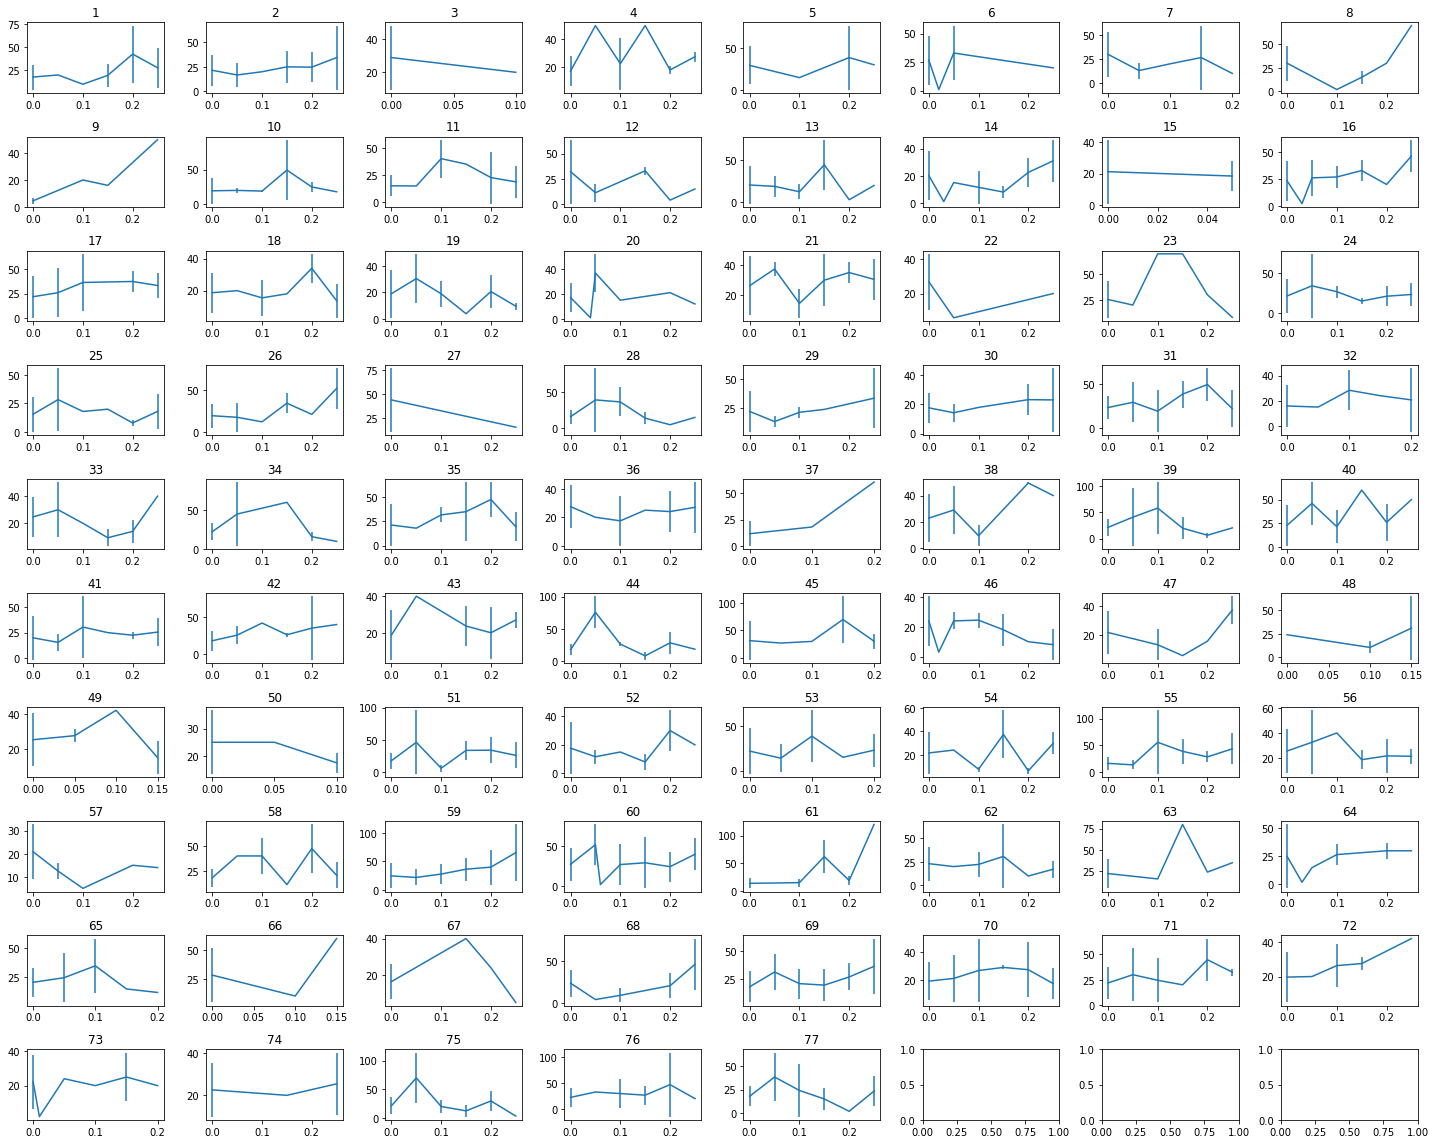

In [201]:
analysis_df = df[['ProductId','Quantity','Discount']]

mean_std_df = analysis_df.groupby(['ProductId','Discount']).agg(['mean','std'])

mean_std_df.reset_index(level=1,inplace=True)

mean_std_df[mean_std_df.index==1]['Quantity']['mean'];

fig, axs = plt.subplots(10,8, figsize=(20, 16))
axs = axs.ravel()
for i in range(77):
    axs[i].errorbar(mean_std_df[mean_std_df.index==i+1]['Discount'],mean_std_df[mean_std_df.index==i+1]['Quantity']['mean'],
                    yerr=mean_std_df[mean_std_df.index==i+1]['Quantity']['std'])
    axs[i].set_title('%i'%(i+1))
plt.tight_layout()
#plt.savefig('Figures/q1_visual.png')

#### Throughout the analysis we need to specify what our hypothesis is. We will set our tolerance value  $\alpha=0.05$. We will be performing the two tailed tests. Our Null hypothesis is that the the quantities ordered at various discount prices have the same mean as that of zero discount price. Our alternative hypothesis is that the means of the distributions at higher discount prices are different from that of discount price zero. Thus this is a two tailed hypothesis test. Since the variance of the two distributions can be different and the sample sizes are not the same we need to do a Welch's t-test. Welch's t-test, even though it's more general than the student's t-test assumes that the underlying "true" distributions are normal, which we also assume here. We will check that more rigorously later

#### Checking if individual discount levels matter

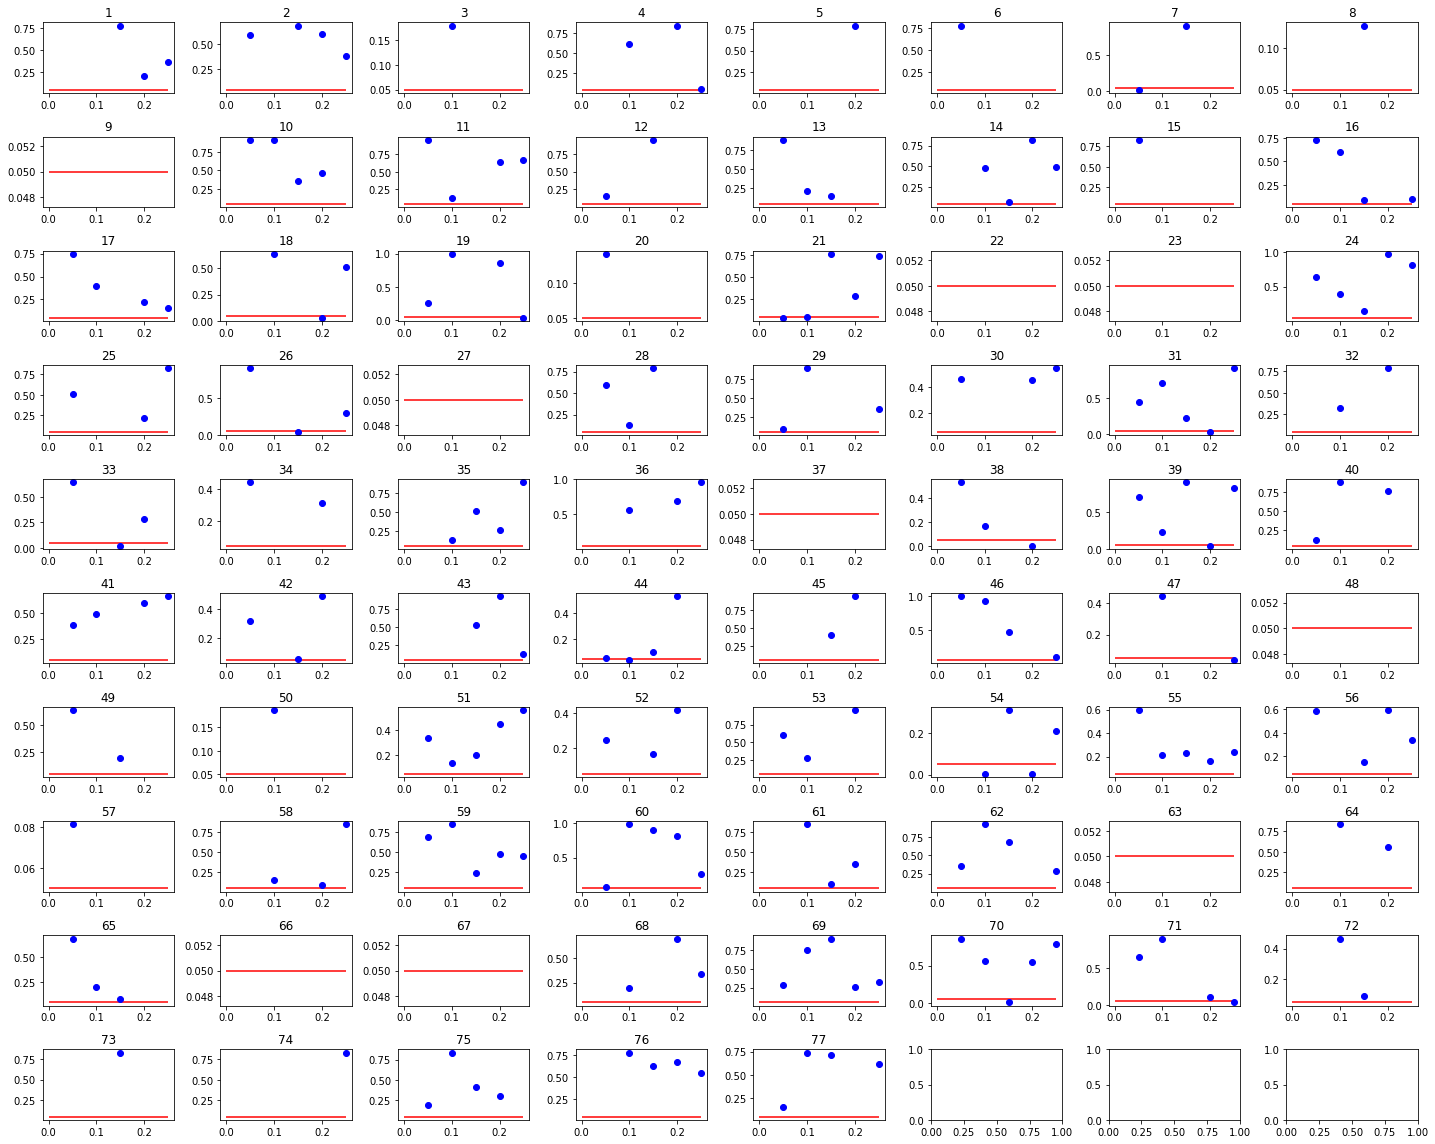

In [67]:
prod_id = analysis_df.ProductId.unique()
prod_id.sort()
p_val_array = []
disc_array = []
for id_ in prod_id:
    df_id = analysis_df[analysis_df.ProductId==id_]
    disc = df_id.Discount.unique()
    disc.sort()
    a = df_id[df_id.Discount==disc[0]]['Quantity']
    p_val = []
    for d in disc[1:]:
        b = df_id[df_id.Discount==d]['Quantity']
        p_val.append(ttest_ind(a,b,equal_var=False)[1])
    disc_array.append(disc[1:])
    p_val_array.append(p_val)


fig, axs = plt.subplots(10,8, figsize=(20, 16))
axs = axs.ravel()
for i in range(77):
    axs[i].hlines(0.05,0.0,0.25,color='r')
    axs[i].plot(disc_array[i],p_val_array[i],'bo')
    axs[i].set_title('%i'%(i+1))
plt.tight_layout()
#plt.title('p-values for Welch t-test for individual products at individual discount prices')
plt.savefig('Figures\welch_all.png')


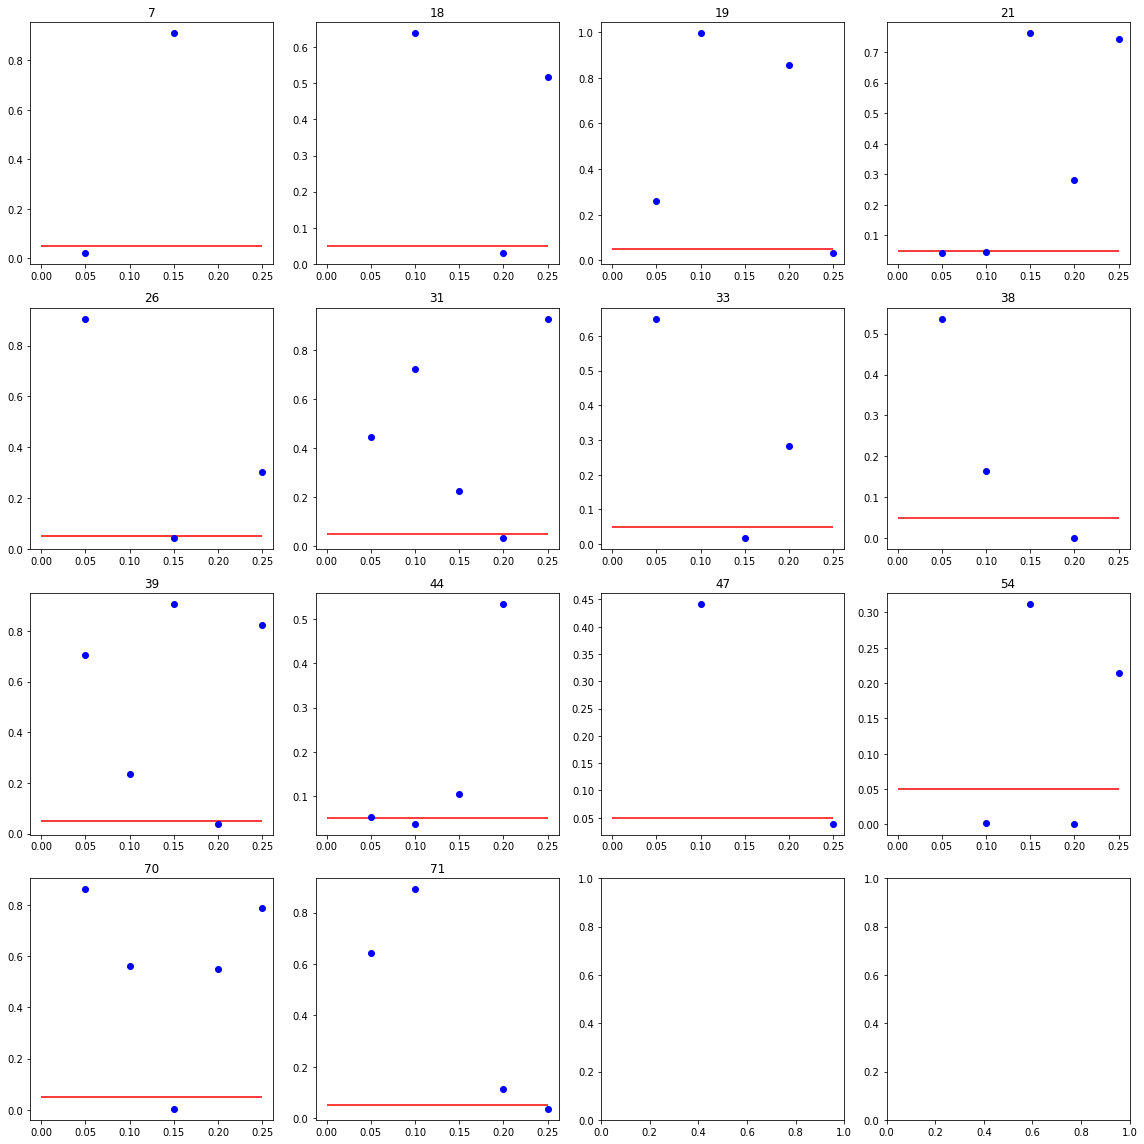

In [69]:
ind = []
for i,p in enumerate(p_val_array):
    s = (np.array(p) < 0.05).sum()
    if s>0:
        ind.append(i)

fig, axs = plt.subplots(4,4, figsize=(16, 16))
axs = axs.ravel()
for i,j in enumerate(ind):

    axs[i].hlines(0.05,0.0,0.25,color='r')
    axs[i].plot(disc_array[j],p_val_array[j],'bo')
    axs[i].set_title('%i'%(j+1))
plt.tight_layout()
plt.savefig('Figures\welch_passed.png')

#### However we have to take into account the Multiple comparison problem or as physicists call it the "look elsewhere" effect . We can correct for it by using the Bonferroni connection where we set the adjusted alpha to original alpha/number of comparisons. Here the number of observations will be all the non-nan entries. This is probably an overkill since we are giving each comparison equal weight

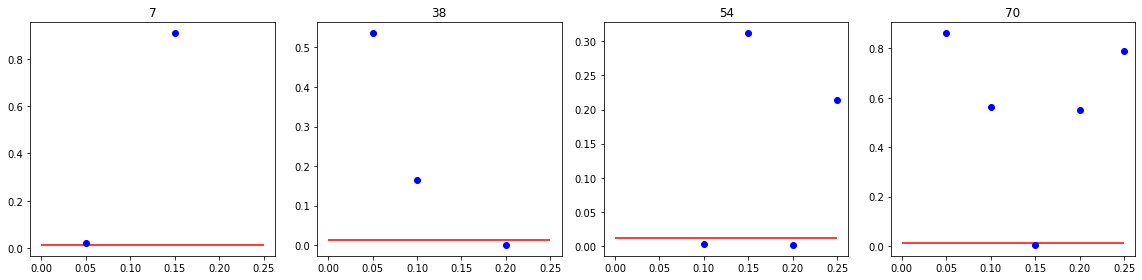

In [72]:
ind_bc = []
for i,p in enumerate(p_val_array):
    #accounting for bonferonni connection
    r = np.invert(np.isnan((p))).sum()
    
    s = (np.array(p) < 0.05/max(1,r)).sum()
    if s>0:
        ind_bc.append(i)

fig, axs = plt.subplots(1,4, figsize=(16, 4))
axs = axs.ravel()
for i,j in enumerate(ind_bc):

    axs[i].hlines(0.05/r,0.0,0.25,color='r')
    axs[i].plot(disc_array[j],p_val_array[j],'bo')
    axs[i].set_title('%i'%(j+1))
plt.tight_layout()
plt.savefig('Figures\welch_passed_bc.png')

#### As we can see taking into account the Bonferonni connection only 4 of the 77 products show any hint that they don't come from the same distribution. This is what is expected if the null hypothesis is true. So there is no evidence that discount rates matter.  There is also no correlation that seems to indicate that higher discount levels have lower p-values. We conclude using the Welch's t-test that there is no indication that discount rates matter but the level of discount cannot be ascetained conclusively

### Testing the normality of the underlying data

### Checking if the zero discount quantities are normally distributed

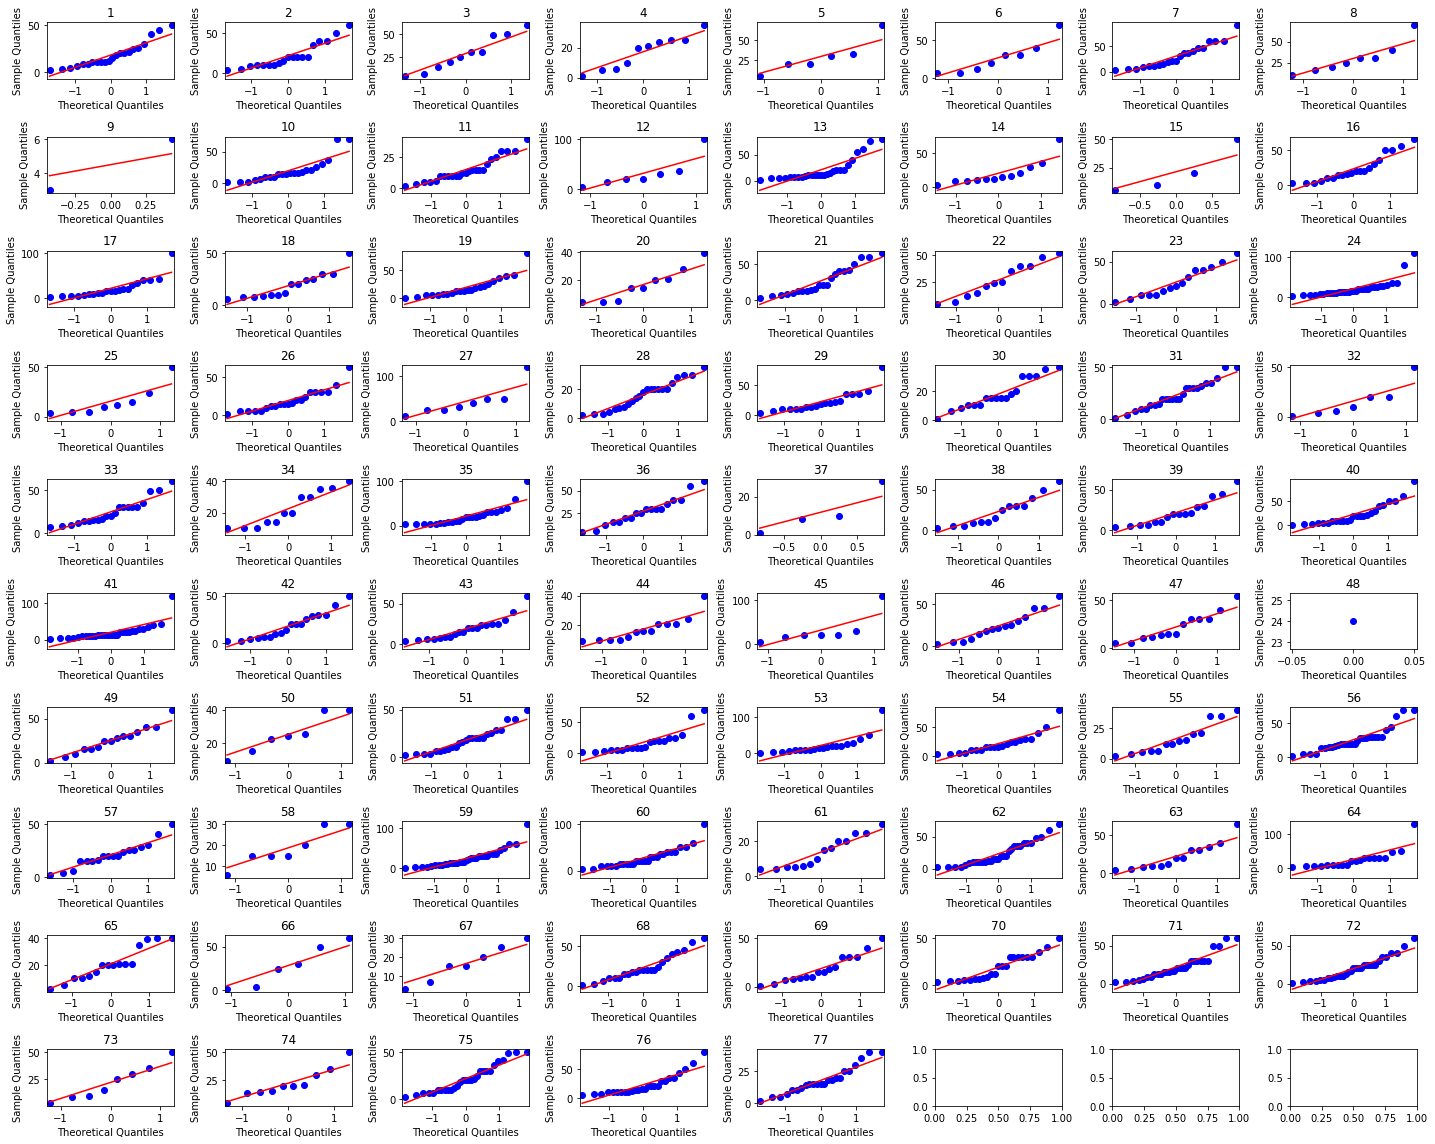

In [73]:
prod_id = analysis_df.ProductId.unique()
prod_id.sort()
q_array = []
disc_array = []
for id_ in prod_id:
    df_id = analysis_df[analysis_df.ProductId==id_]
    disc = df_id.Discount.unique()
    disc.sort()
    a = df_id[df_id.Discount==disc[0]]['Quantity']
    q_array.append(a)

fig, axs = plt.subplots(10,8, figsize=(20, 16))
axs = axs.ravel()
for i in range(77):
    sm.qqplot(q_array[i],line='s',ax=axs[i])
    axs[i].set_title('%i'%(i+1))
plt.tight_layout()
#plt.title('p-values for Welch t-test for individual products at individual discount prices')
plt.savefig('Figures\qq_all.png')

#### They look reasonably normal. Let's run the KS normality test on all the discounts for all the products

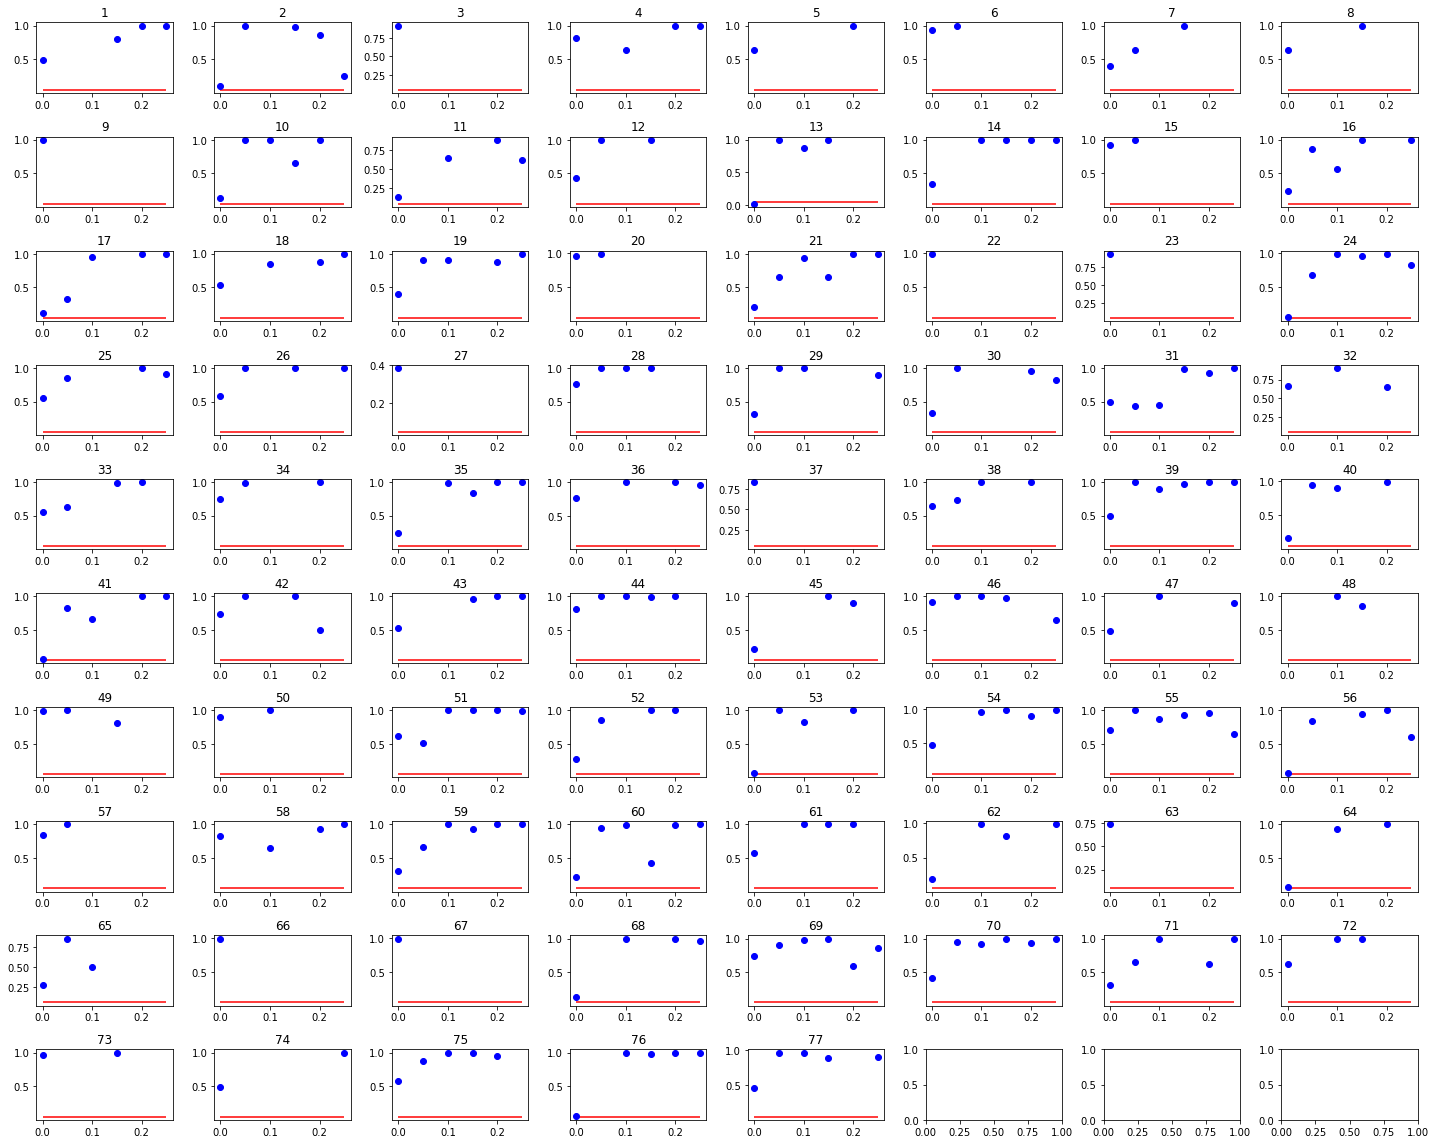

In [46]:
prod_id = analysis_df.ProductId.unique()
prod_id.sort()
ks_norm_array = []
disc_array = []
for id_ in prod_id:
    df_id = analysis_df[analysis_df.ProductId==id_]
    disc = df_id.Discount.unique()
    disc.sort()
    p_val = []
    for d in disc:
        a = df_id[df_id.Discount==d]['Quantity']
        b = (a-a.mean())/a.std()
#        print(b.mean(),b.std())
        p_val.append(kstest(b,'norm',alternative='two-sided',mode='approx')[1])
#    print('pval ',p_val)
    disc_array.append(disc)
    ks_norm_array.append(p_val)



fig, axs = plt.subplots(10,8, figsize=(20, 16))
axs = axs.ravel()
for i in range(77):
    axs[i].hlines(0.05,0.0,0.25,color='r')
    axs[i].plot(disc_array[i],ks_norm_array[i],'bo')
    axs[i].set_title('%i'%(i+1))
plt.tight_layout()
#plt.title('p-values for Welch t-test for individual products at individual discount prices')
plt.savefig('Figures\ks_norm_all.png')


#### Almost all the data is very consistent with normality. So our Welch's test assumption was justified.

#### Now we can try to run the Kolmogorov–Smirnov test. The reason for this is that our distribution way not be drawn from an underlying normal distribution which the Welch's t-test assumes. The KS test is more general however it has it's own shortcomings

In [103]:
prod_id = analysis_df.ProductId.unique()
prod_id.sort()
p_val_array_ks_disc = []
for id_ in prod_id:
    df_id = analysis_df[analysis_df.ProductId==id_]
    disc = df_id.Discount.unique()
    disc.sort()
    a = df_id[df_id.Discount==disc[0]]['Quantity']
    b = df_id[df_id.Discount!=disc[0]]['Quantity']
    p_val_array_ks_disc.append(ks_2samp(a,b)[1])

print('The number of products that have a p-value < 0.05 is ', (np.array(p_val_array_ks_disc) < 0.05).sum(), ' whereas the expected number under the null hypothesis', round(len(prod_id)*0.05) )

The number of products that have a p-value < 0.05 is  2  whereas the expected number under the null hypothesis 4


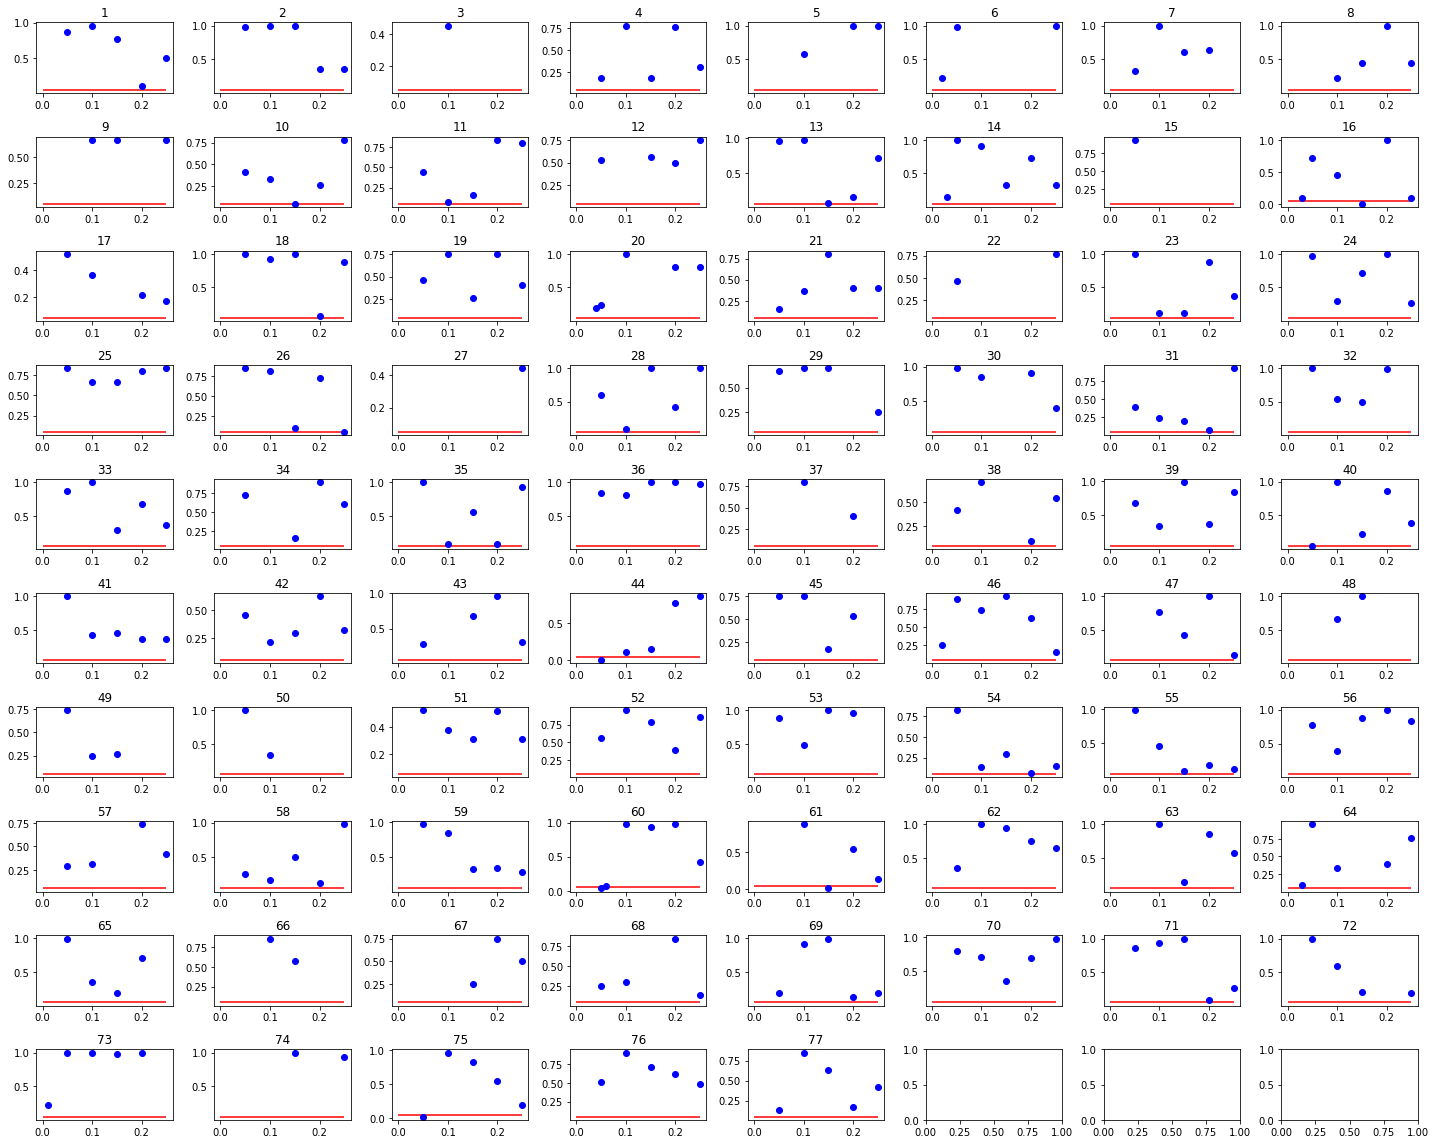

In [14]:
prod_id = analysis_df.ProductId.unique()
prod_id.sort()
p_val_array_ks = []
disc_array_ks = []
for id_ in prod_id:
    df_id = analysis_df[analysis_df.ProductId==id_]
    disc = df_id.Discount.unique()
    disc.sort()
    a = df_id[df_id.Discount==disc[0]]['Quantity']
    p_val = []
    for d in disc[1:]:
        b = df_id[df_id.Discount==d]['Quantity']
        p_val.append(ks_2samp(a,b)[1])
    disc_array_ks.append(disc[1:])
    p_val_array_ks.append(p_val)


fig, axs = plt.subplots(10,8, figsize=(20, 16))
axs = axs.ravel()
for i in range(77):
    axs[i].hlines(0.05,0.0,0.25,color='r')
    axs[i].plot(disc_array_ks[i],p_val_array_ks[i],'bo')
    axs[i].set_title('%i'%(i+1))
plt.tight_layout()


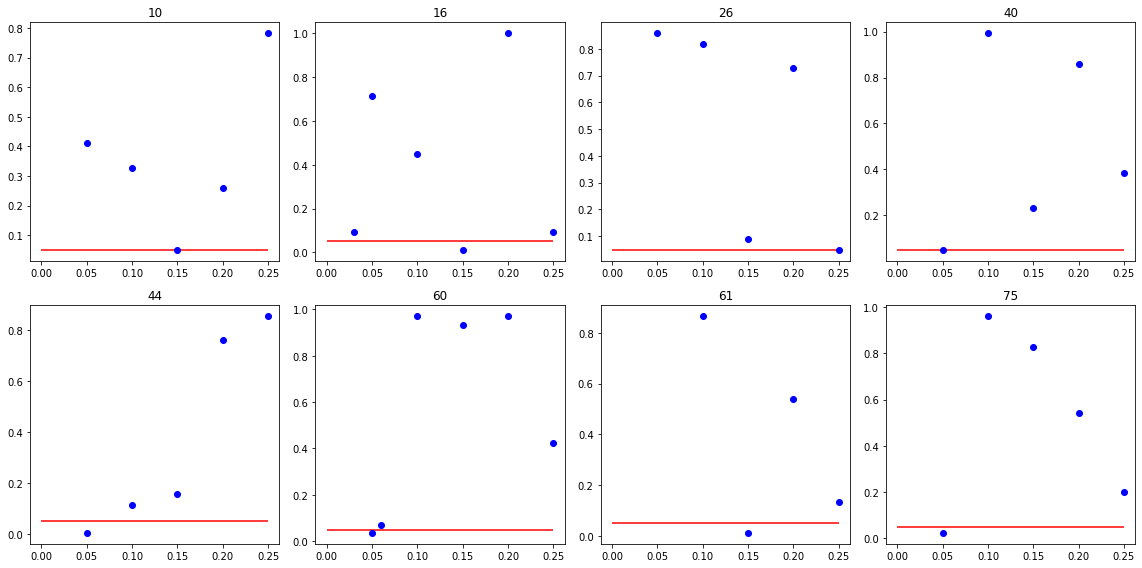

In [17]:
ind_ks = []
for i,p in enumerate(p_val_array_ks):
    s = (np.array(p) < 0.05).sum()
    if s>0:
        ind_ks.append(i)

fig, axs = plt.subplots(2,4, figsize=(16, 8))
axs = axs.ravel()
for i,j in enumerate(ind_ks):

    axs[i].hlines(0.05,0.0,0.25,color='r')
    axs[i].plot(disc_array_ks[j],p_val_array_ks[j],'bo')
    axs[i].set_title('%i'%(j+1))
plt.tight_layout()

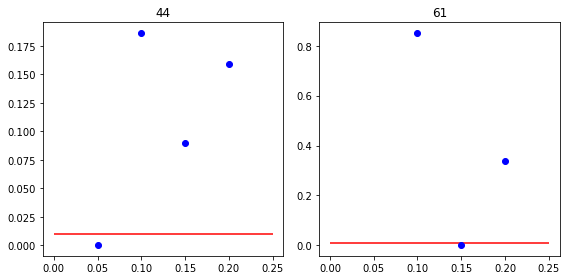

In [24]:
ind_ks_bc = []
for i,p in enumerate(p_val_array_ks):
    #accounting for bonferonni connection
    r = np.invert(np.isnan((p))).sum()
    
    s = (np.array(p) < 0.05/max(1,r)).sum()
    if s>0:
        ind_ks_bc.append(i)

fig, axs = plt.subplots(1,2, figsize=(8, 4))
axs = axs.ravel()
for i,j in enumerate(ind_ks_bc):
    axs[i].hlines(0.05/r,0.0,0.25,color='r')
    axs[i].plot(disc_array[j],p_val_array[j],'bo')
    axs[i].set_title('%i'%(j+1))
plt.tight_layout()


#### After accounting for the Bonferroni connection only 2 products survive the KS test. Hence there is no indication that there is a discernible effect of discounts on order quantities

## Q2 Does the month the product was ordered matter for the quantity. Do sales get better year on year?

In [117]:
conn = sqlite3.Connection('Northwind_small.sqlite')
cur = conn.cursor()

In [118]:
cur.execute("""SELECT OrderId, ProductId, UnitPrice, Quantity, Discount, OrderDate,EmployeeId
               FROM orderdetail
               JOIN "order"
               ON orderdetail.OrderId = "order".Id
               """)
df = pd.DataFrame(cur.fetchall()) #Take results and create dataframe
df.columns = [i[0] for i in cur.description]
df.head()

,OrderId,ProductId,UnitPrice,Quantity,Discount,OrderDate,EmployeeId
0,10248,11,14.0,12,0.0,2012-07-04,5
1,10248,42,9.8,10,0.0,2012-07-04,5
2,10248,72,34.8,5,0.0,2012-07-04,5
3,10249,14,18.6,9,0.0,2012-07-05,6
4,10249,51,42.4,40,0.0,2012-07-05,6


In [119]:
df['month'] = pd.DatetimeIndex(df.OrderDate).month
df['year'] = pd.DatetimeIndex(df.OrderDate).year
df.drop('OrderDate',axis=1,inplace=True)

### Are there any products that are statistically performing worse than when we started selling and need to be discontinued? Are there any products that are doing much better and need to be supported?

In [121]:
df.year.unique()

array([2012, 2013, 2014], dtype=int64)

#### Since there are only 3 years we can do a t-test for each year and see if there are differences

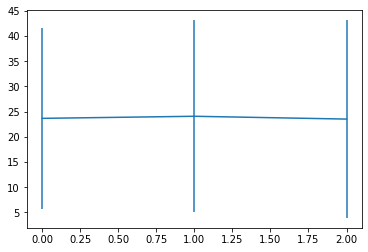

In [122]:
mean = []
std = []
for i in range(3):
    mean.append(df[df.year==i+2012]['Quantity'].mean())
    std.append(df[df.year==i+2012]['Quantity'].std())

plt.errorbar(range(3),mean,yerr=std);


In [126]:
p_val_matrix_yr = np.zeros([3,3])
for i in range(2012,2015):
    for j in range(2012,2015):
        df_samp_1 = df[df.year==i]['Quantity']
        df_samp_2 = df[df.year==j]['Quantity']
        p_val_matrix_yr[i-2012,j-2012] = ttest_ind(df_samp_1,df_samp_2,equal_var=False)[1]
p_val_matrix_yr

array([[1.        , 0.69955893, 0.90119081],
       [0.69955893, 1.        , 0.55716325],
       [0.90119081, 0.55716325, 1.        ]])

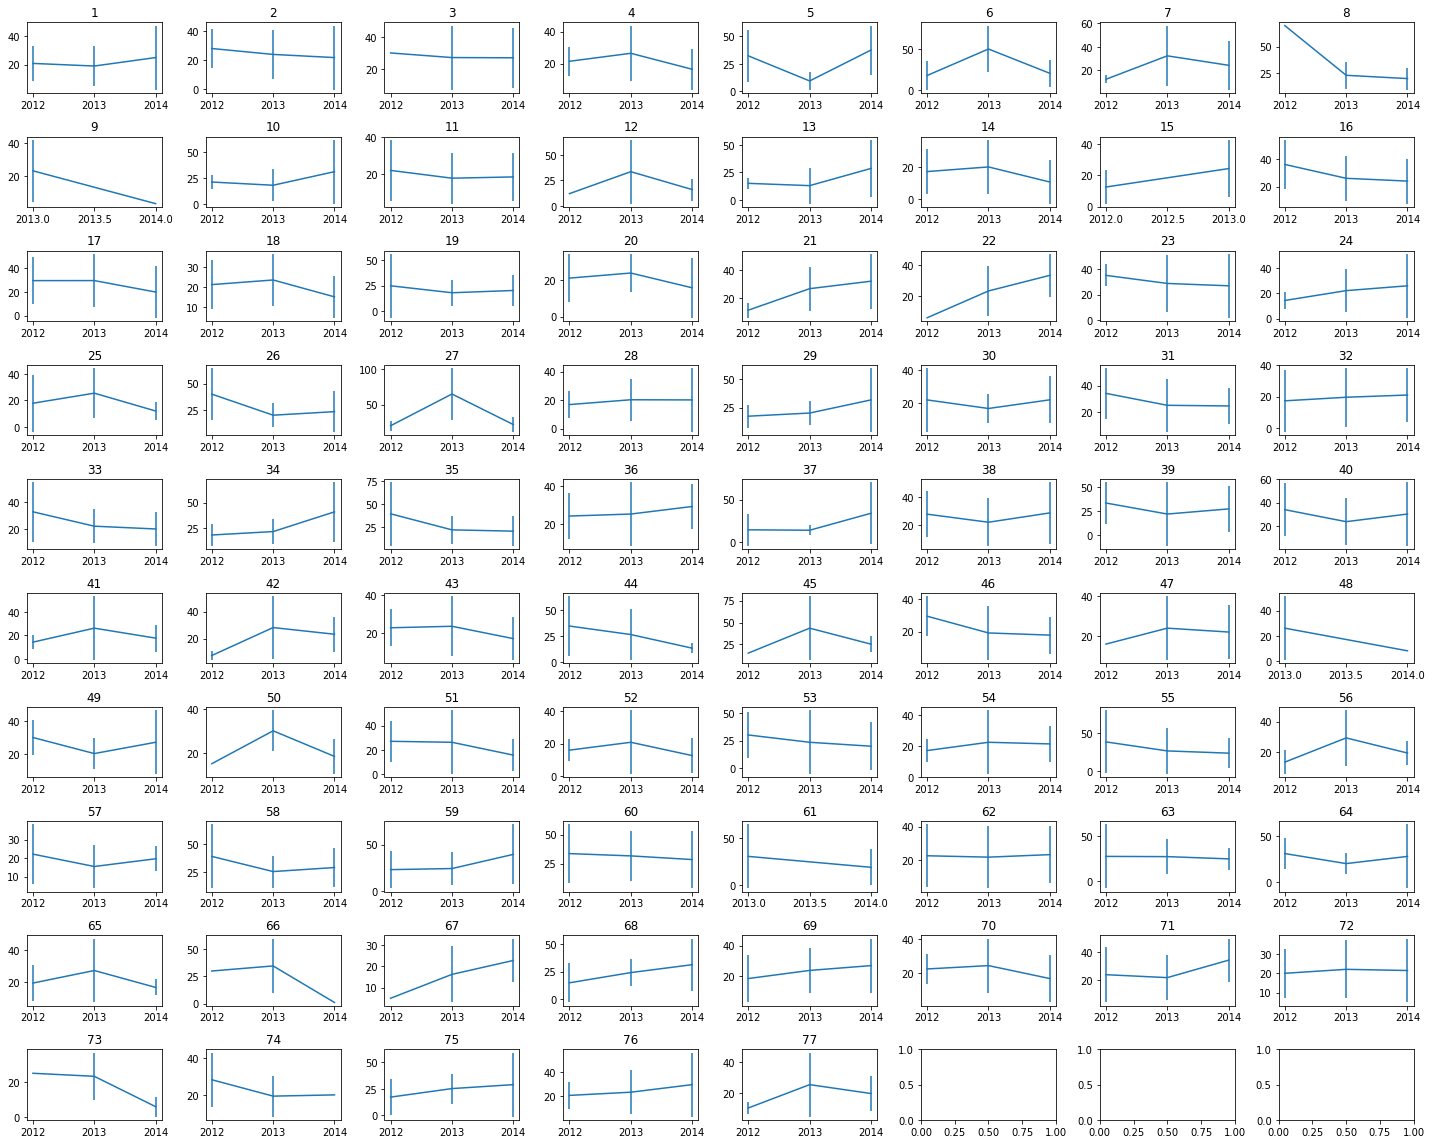

In [130]:
mean_std_df = df.groupby(['ProductId','year']).agg(['mean','std'])

mean_std_df.reset_index(level=1,inplace=True)

fig, axs = plt.subplots(10,8, figsize=(20, 16))
axs = axs.ravel()
for i in range(77):
    axs[i].errorbar(mean_std_df[mean_std_df.index==i+1]['year'],mean_std_df[mean_std_df.index==i+1]['Quantity']['mean'],
                    yerr=mean_std_df[mean_std_df.index==i+1]['Quantity']['std'])
    axs[i].set_title('%i'%(i+1))
plt.tight_layout()
#plt.savefig('Figures/q1_visual.png')

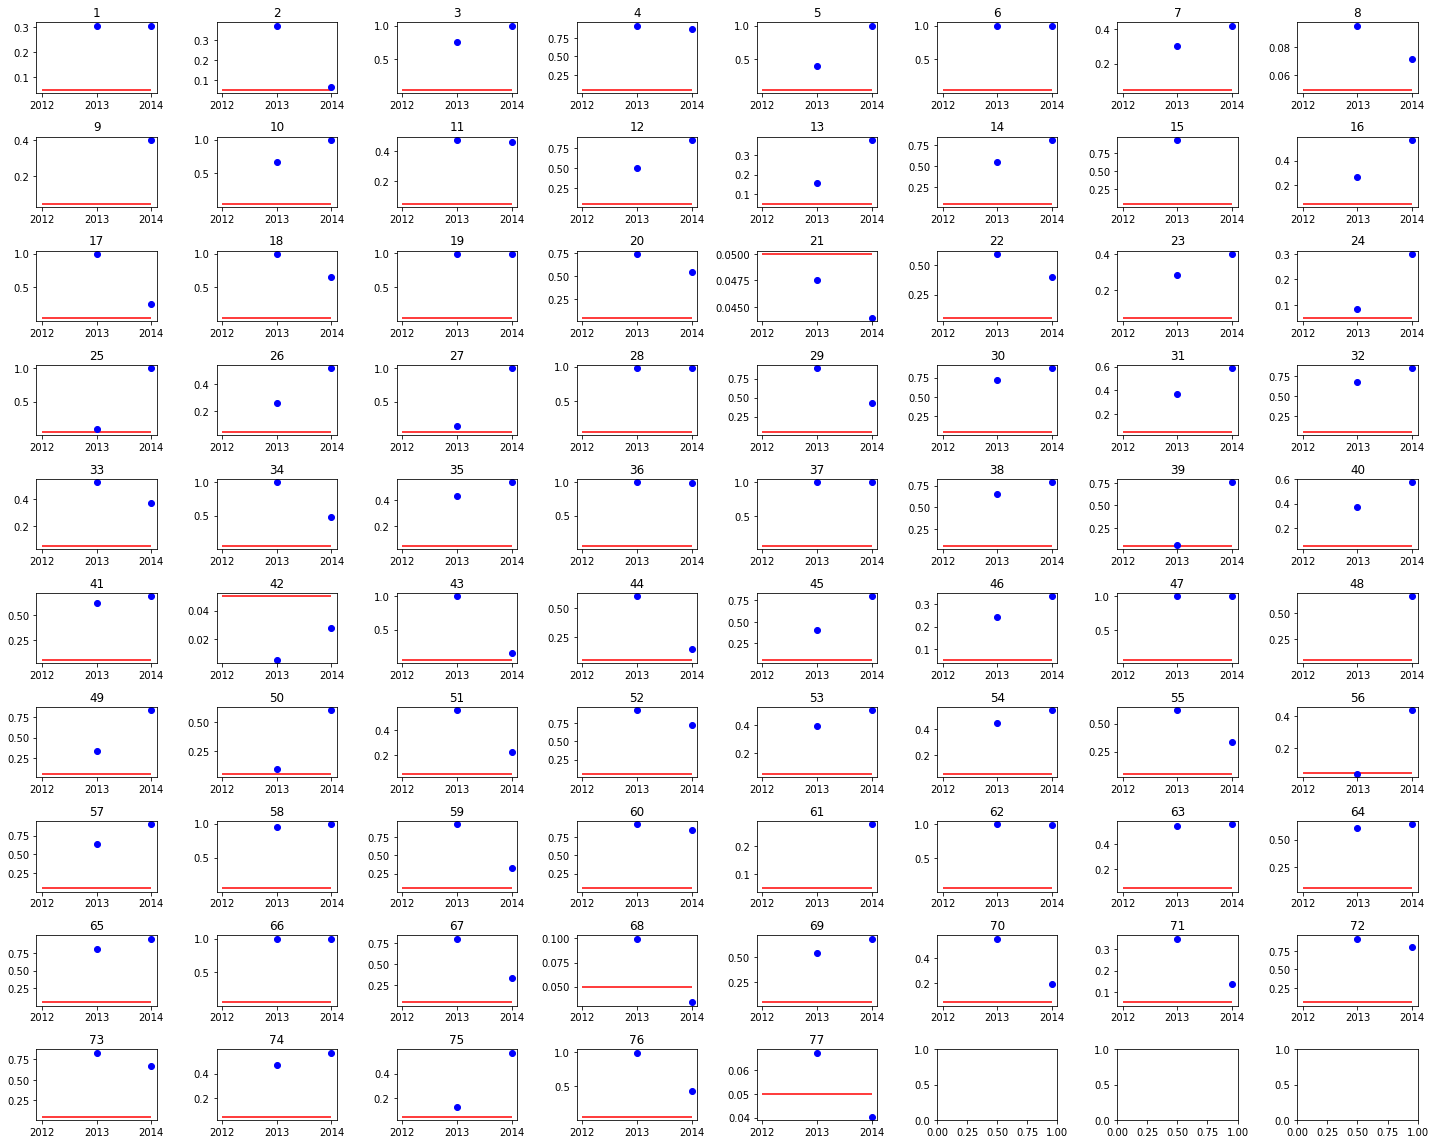

In [138]:
prod_id = df.ProductId.unique()
prod_id.sort()
p_val_array_yr = []
yr_array = []
for id_ in prod_id:
    df_id = df[df.ProductId==id_]
    yr = df_id.year.unique()
    yr.sort()
    a = df_id[df_id.year==yr[0]]['Quantity']
    p_val = []
    for d in yr[1:]:
        b = df_id[df_id.year==d]['Quantity']
        p_val.append(ks_2samp(a,b)[1])
    yr_array.append(yr[1:])
    p_val_array_yr.append(p_val)


fig, axs = plt.subplots(10,8, figsize=(20, 16))
axs = axs.ravel()
for i in range(77):
    axs[i].hlines(0.05,2012,2014,color='r')
    axs[i].plot(yr_array[i],p_val_array_yr[i],'bo')
    axs[i].set_title('%i'%(i+1))
plt.tight_layout()
#plt.title('p-values for Welch t-test for individual products at individual discount prices')
plt.savefig('Figures\welch_all_yr.png')

In [136]:
ind_ks_yr

[20, 41, 55, 67, 76]

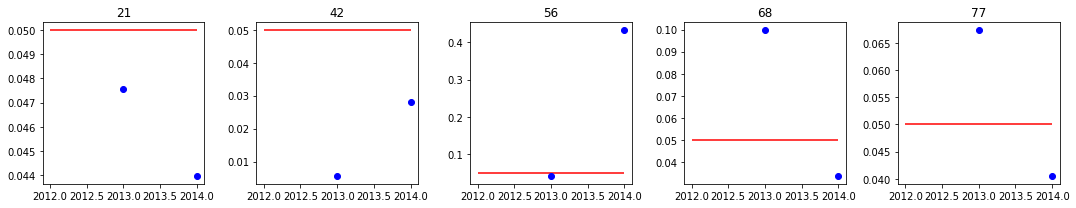

In [141]:
ind_ks_yr = []
for i,p in enumerate(p_val_array_yr):
    s = (np.array(p) < 0.05).sum()
    if s>0:
        ind_ks_yr.append(i)

fig, axs = plt.subplots(1,5, figsize=(15, 3))
axs = axs.ravel()
for i,j in enumerate(ind_ks_yr):

    axs[i].hlines(0.05,2012,2014,color='r')
    axs[i].plot(yr_array[j],p_val_array_yr[j],'bo')
    axs[i].set_title('%i'%(j+1))
plt.tight_layout()

#### Only 5 products seem to indicate that the produts differ from original sales. We expect 4 if null hypothesis is true. Hence no products indicate a significant change in sales

### Doing an ANOVA analysis for month

In [128]:
formula = 'Quantity ~ C(month)'
lm = ols(formula, df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                 sum_sq      df         F    PR(>F)
C(month)    7395.980026    11.0  1.866405  0.039229
Residual  772003.656168  2143.0       NaN       NaN


#### Seems like its a little important. Let's do what we are not supposed to do, i.e. make one to one comparisons for each month

In [84]:
p_val_matrix = np.zeros([12,12])
for i in range(1,13):
    for j in range(1,13):
        df_samp_1 = df[df.month==i]['Quantity']
        df_samp_2 = df[df.month==j]['Quantity']
        p_val_matrix[i-1,j-1] = ttest_ind(df_samp_1,df_samp_2,equal_var=False)[1]
        

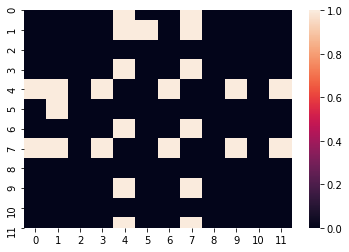

In [95]:
sns.heatmap(p_val_matrix < 0.05)

#### As can be seen months May and August seem special in that they have the most deviations from other months. Lets plot them to visualize it

<ErrorbarContainer object of 3 artists>

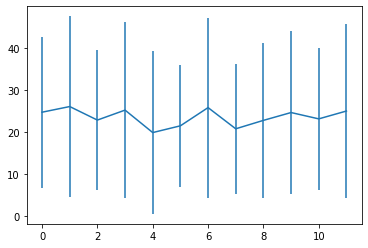

In [113]:
mean = []
std = []
for i in range(12):
    mean.append(df[df.month==i+1]['Quantity'].mean())
    std.append(df[df.month==i+1]['Quantity'].std())

plt.errorbar(range(12),mean,yerr=std)



#### Although not visually compelling it seems that May and August have downward fluctuations in sales

## Q3 Is there a standout employee?

In [142]:
cur.execute("""SELECT OrderId, ProductId, UnitPrice, Quantity, Discount, OrderDate, ShippedDate,RequiredDate, EmployeeId
               FROM orderdetail
               JOIN "order"
               ON orderdetail.OrderId = "order".Id
               """)
df = pd.DataFrame(cur.fetchall()) #Take results and create dataframe
df.columns = [i[0] for i in cur.description]
df.head()

,OrderId,ProductId,UnitPrice,Quantity,Discount,OrderDate,ShippedDate,RequiredDate,EmployeeId
0,10248,11,14.0,12,0.0,2012-07-04,2012-07-16,2012-08-01,5
1,10248,42,9.8,10,0.0,2012-07-04,2012-07-16,2012-08-01,5
2,10248,72,34.8,5,0.0,2012-07-04,2012-07-16,2012-08-01,5
3,10249,14,18.6,9,0.0,2012-07-05,2012-07-10,2012-08-16,6
4,10249,51,42.4,40,0.0,2012-07-05,2012-07-10,2012-08-16,6


In [146]:
df['EmployeeId'].unique()

array([5, 6, 4, 3, 9, 1, 8, 2, 7], dtype=int64)

<ErrorbarContainer object of 3 artists>

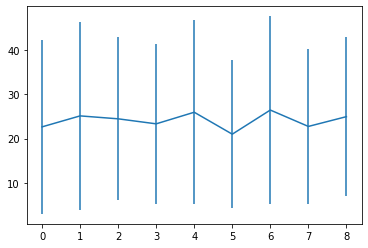

In [147]:
mean = []
std = []
for i in range(9):
    mean.append(df[df.EmployeeId==i+1]['Quantity'].mean())
    std.append(df[df.EmployeeId==i+1]['Quantity'].std())

plt.errorbar(range(9),mean,yerr=std)


In [148]:
formula = 'Quantity ~ C(EmployeeId)'
lm = ols(formula, df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                      sum_sq      df         F   PR(>F)
C(EmployeeId)    4643.183282     8.0  1.607646  0.11745
Residual       774756.452913  2146.0       NaN      NaN


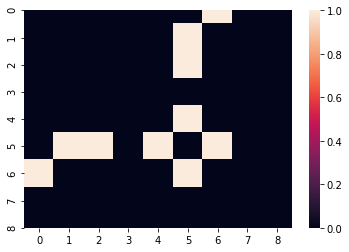

In [153]:
p_val_matrix_eid = np.zeros([9,9])
for i in range(1,10):
    for j in range(1,10):
        df_samp_1 = df[df.EmployeeId==i]['Quantity']
        df_samp_2 = df[df.EmployeeId==j]['Quantity']
        p_val_matrix_eid[i-1,j-1] = ttest_ind(df_samp_1,df_samp_2,equal_var=False)[1]
sns.heatmap(p_val_matrix_eid < 0.05)

### Is there a employee who does not ship on time compared to the other employees?

In [162]:
late_dict = df[df.ShippedDate > df.RequiredDate]['EmployeeId'].value_counts().to_dict()
tot_sales = df['EmployeeId'].value_counts().to_dict()

In [173]:
prob_dict = {k : late_dict[k]/tot_sales[k] for k in late_dict.keys()}

In [185]:
prob_dict

{4: 0.06428571428571428,
 2: 0.058091286307053944,
 3: 0.040498442367601244,
 7: 0.056818181818181816,
 8: 0.03461538461538462,
 9: 0.07476635514018691,
 6: 0.02976190476190476,
 1: 0.014492753623188406,
 5: 0.008547008547008548}

In [187]:
def z_stat(p1,n1,p2,n2):
    p = (p1*n1+p2*n2)/(n1+n2)
    z = (p1-p2)/np.sqrt(p*(1-p)*(1/n1 + 1/n2))
    return abs(z)

In [190]:
late_dict.keys()

dict_keys([4, 2, 3, 7, 8, 9, 6, 1, 5])

### Designating employee 5 as the best employee in terms of deliveries on time, we perform z-tests to ask the question which employees need to pick up the pace. For a 2 -tailed test with $\alpha=0.05$ we get that for z > 1.96 the employees satisfy our alternative hypothesis are 4,2,7 and 9. We need to tell them to pick it up a little. However we need to be careful no to make it such an overwhelming metric that if falls victim to Goodheart's law

In [189]:
zlist = []
for k in late_dict.keys():
    p1 = prob_dict[5]
    n1 = tot_sales[5]
    p2 = prob_dict[k]
    n2 = tot_sales[k]
    zlist.append(z_stat(p1,n1,p2,n2))
zlist

[2.3984114685786966,
 2.1945413975106156,
 1.6819996770998709,
 2.1288743681543547,
 1.457240475422366,
 2.5208861680635817,
 1.2272504115606684,
 0.49087589323674585,
 0.0]

In [196]:
zlist = []
for k in late_dict.keys():
    p1 = sum(late_dict.values())/sum(tot_sales.values())
    n1 = sum(tot_sales.values())
    p2 = prob_dict[k]
    n2 = tot_sales[k]
    zlist.append(z_stat(p1,n1,p2,n2))
zlist

[1.9283610334650696,
 1.1026101202677772,
 0.1818964909579171,
 0.8809246341542263,
 0.6145036624796331,
 1.5754326142124007,
 0.8069312241426284,
 2.51807657985541,
 1.815391149495167]

# Are there regions that are growing or decreasing in sales? Are there standout customers in a given region?

In [187]:
conn = sqlite3.Connection('Northwind_small.sqlite')
cur = conn.cursor()

In [188]:
cur.execute("""SELECT Customer.Id,Region,Country,"order".Id as OrderId,EmployeeId,ProductId,UnitPrice,Quantity, OrderDate
               FROM Customer
               JOIN "order"
               ON Customer.Id="order".CustomerId
               JOIN orderdetail
               ON "order".Id = orderdetail.OrderId
               """)

In [189]:
df = pd.DataFrame(cur.fetchall()) #Take results and create dataframe
df.columns = [i[0] for i in cur.description]
df['year'] = pd.DatetimeIndex(df.OrderDate).year
df.head(10)

,Id,Region,Country,OrderId,EmployeeId,ProductId,UnitPrice,Quantity,OrderDate,year
0,VINET,Western Europe,France,10248,5,11,14.0,12,2012-07-04,2012
1,VINET,Western Europe,France,10248,5,42,9.8,10,2012-07-04,2012
2,VINET,Western Europe,France,10248,5,72,34.8,5,2012-07-04,2012
3,TOMSP,Western Europe,Germany,10249,6,14,18.6,9,2012-07-05,2012
4,TOMSP,Western Europe,Germany,10249,6,51,42.4,40,2012-07-05,2012
5,HANAR,South America,Brazil,10250,4,41,7.7,10,2012-07-08,2012
6,HANAR,South America,Brazil,10250,4,51,42.4,35,2012-07-08,2012
7,HANAR,South America,Brazil,10250,4,65,16.8,15,2012-07-08,2012
8,VICTE,Western Europe,France,10251,3,22,16.8,6,2012-07-08,2012
9,VICTE,Western Europe,France,10251,3,57,15.6,15,2012-07-08,2012


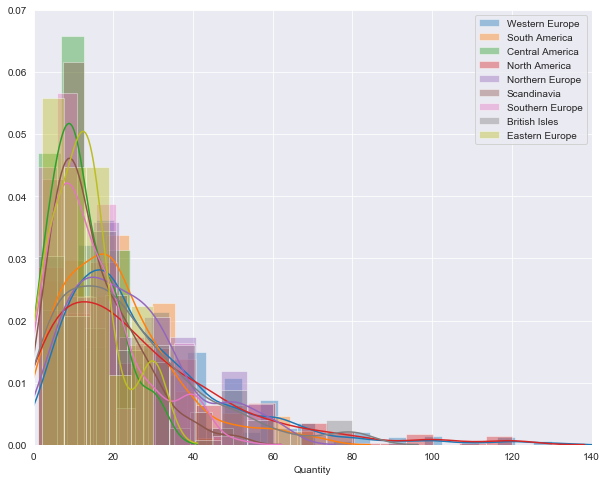

In [176]:
plt.figure(figsize=(10,8))
plt.ylim([0,0.07])
plt.xlim([0,140])
for region in df.Region.unique():
    df_r = df[df.Region==region]
#    print(len(df_r))
    sns.distplot(df_r['Quantity'],label=region);
plt.legend()

In [231]:
for region in df.Region.unique():
    df_we = df[df.Region==region]
    yr = df_we.year.unique()
    df_we_min = df_we[df_we.year==yr.min()]
    df_we_max = df_we[df_we.year==yr.max()]
#    sns.distplot(df_we_min['Quantity'])
#    sns.distplot(df_we_max['Quantity'])
    print(region,ttest_ind(np.log1p(df_we_min['Quantity']),np.log1p(df_we_max['Quantity']),equal_var=False)[1])

Western Europe 0.6596324248219092
South America 0.8300100507977594
Central America 0.2762677213685358
North America 0.027441517578318624
Northern Europe 0.6688243235437248
Scandinavia 0.014547237177134813
Southern Europe 0.789323220763125
British Isles 0.9048962276210881
Eastern Europe 0.19672322791799002


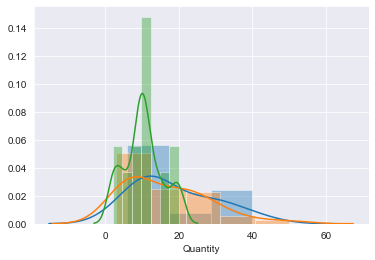

In [228]:
sns.distplot(df[(df.Region=='Scandinavia') & (df.year==2012)]['Quantity'])
sns.distplot(df[(df.Region=='Scandinavia') & (df.year==2013)]['Quantity'])
sns.distplot(df[(df.Region=='Scandinavia') & (df.year==2014)]['Quantity'])

['VINET' 'TOMSP' 'VICTE' 'SUPRD' 'CHOPS' 'RICSU' 'ERNSH' 'OTTIK' 'BLONP'
 'FRANK' 'QUICK' 'MORGK' 'LEHMS' 'WANDK' 'KOENE' 'BONAP' 'LAMAI' 'PICCO'
 'DRACD' 'FOLIG' 'BLAUS' 'MAISD' 'ALFKI' 'FRANR' 'SPECD' 'LACOR']


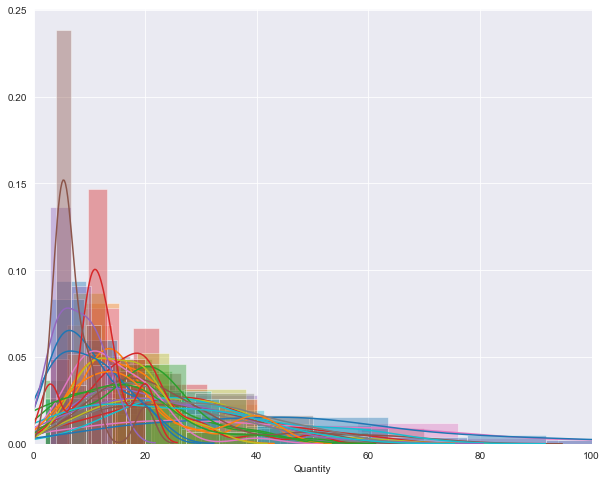

In [240]:
plt.figure(figsize=(10,8))
plt.xlim([0,100])
for region in df.Region.unique()[0:1]:
    df_we = df[df.Region==region]
    customer = df_we.Id.unique()
    print(customer)
    for c in customer:
        sns.distplot(df_we[df_we.Id==c]['Quantity'])


# Products

In [247]:
cur.execute("""SELECT *
                FROM product
               """)

In [248]:
df = pd.DataFrame(cur.fetchall()) #Take results and create dataframe
df.columns = [i[0] for i in cur.description]
df

,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,1,1,10 boxes x 20 bags,18.00,39,0,10,0
1,2,Chang,1,1,24 - 12 oz bottles,19.00,17,40,25,0
2,3,Aniseed Syrup,1,2,12 - 550 ml bottles,10.00,13,70,25,0
3,4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.00,53,0,0,0
4,5,Chef Anton's Gumbo Mix,2,2,36 boxes,21.35,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
72,73,Röd Kaviar,17,8,24 - 150 g jars,15.00,101,0,5,0
73,74,Longlife Tofu,4,7,5 kg pkg.,10.00,4,20,5,0
74,75,Rhönbräu Klosterbier,12,1,24 - 0.5 l bottles,7.75,125,0,25,0
75,76,Lakkalikööri,23,1,500 ml,18.00,57,0,20,0


In [245]:
df.shape

(77, 10)